# Modified TPC-H Q1 Microbenchmark
This file is adapted to use numpy only without Spark.

As rewritten by Chorus: (Epsilon = 0.1)
```sql
SELECT
    COUNT(*) + 20.0 * (CASE WHEN random() - 0.5 < 0 THEN -1.0 ELSE 1.0 END * LN(1 - 2 * ABS(random() - 0.5))) AS count_order
FROM 
    (SELECT l_returnflag, l_linestatus, l_shipdate FROM lineitem) AS t
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
    AND l_returnflag = 'A'
    AND l_linestatus = 'F'
```

In [28]:
EXPERIMENT = 'pac-duckdb-q1'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True
USE_EVEN_NUMBER_OF_INPUT_ROWS = False
SEED_RANDOM_NUMBER_GENERATOR = True

SAMPLING_METHOD = 'poisson' # 'poisson' or 'half'

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENERATE = True, so we will generate new samples.


### Running PAC

In [2]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
if SEED_RANDOM_NUMBER_GENERATOR:
    np.random.seed(0)

import polars as pl
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator
from IPython.display import display, HTML
from datetime import date
import duckdb

In [ ]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [12]:
### Data Setup
con = duckdb.connect(database=':memory:')
#tables = ["customer", "lineitem", "nation", "orders", "part", "partsupp", "region", "supplier"]
tables = ["lineitem", "orders"]
for t in tables:
    con.execute(f"CREATE TABLE {t} AS SELECT * FROM 'data/tpch/{t}.parquet'")

lineitem_df = con.execute("SELECT * FROM lineitem").pl()
orders_df = con.execute("SELECT * FROM orders").pl()

row_count = lineitem_df.shape[0]

# Construct the table of random samples
# to use, join it with the lineitem table (for specific sample # s) and filter to just the
# rows where random_binary = 1.0
# This will give us a 50% sample of the lineitem table for each sample # s

SAMPLES = 1024
TABLE_TO_SAMPLE = 'lineitem'
assert SAMPLES % 2 == 0, "SAMPLES must be even to create complementary samples."

con.execute(f"""
CREATE TABLE random_samples AS
WITH sample_numbers AS (
    SELECT range AS sample_id FROM range({SAMPLES//2})
),
random_values AS (
    SELECT 
        sample_numbers.sample_id, 
        {TABLE_TO_SAMPLE}.rowid AS row_id,
        FLOOR(RANDOM() * 2) AS random_binary
    FROM sample_numbers
    JOIN {TABLE_TO_SAMPLE} ON TRUE  -- Cross join to duplicate rows for each sample
)
SELECT
    sample_id,
    row_id,
    random_binary
FROM random_values
UNION ALL
SELECT -- select the complementary samples too
    {SAMPLES//2} + sample_id,
    row_id,
    1 - random_binary  -- Inverse the random_binary to get the complementary sample
FROM random_values;
""")


con.execute("""
PREPARE count_orders AS 
SELECT
    l_returnflag,
    l_linestatus,
    2*sum(l_quantity) AS sum_qty,
    2*sum(l_extendedprice) AS sum_base_price,
    2*sum(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    2*sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    avg(l_quantity) AS avg_qty,
    avg(l_extendedprice) AS avg_price,
    avg(l_discount) AS avg_disc,
    2*count(*) AS count_order
FROM
    lineitem
JOIN random_samples AS rs
    ON rs.row_id = lineitem.rowid
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
    AND rs.random_binary = 1.0
    AND rs.sample_id = $sample
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;
""")

In [17]:
sample_sizes = con.sql("""
SELECT SUM(random_binary) AS sample_size
FROM random_samples
GROUP BY sample_id;
""").pl()
sample_sizes

sample_size
f64
300304.0
299897.0
301024.0
299797.0
299976.0
…
299601.0
300118.0
300061.0


In [ ]:
raw_samples: List[pl.DataFrame] = []
for s in range(SAMPLES):
    raw_samples.append(con.execute(f"EXECUTE count_orders(sample := {s});").pl())
#with open(f'{OUTPUT_DIR}/raw_samples.pickle', 'wb') as f:
#    pickle.dump(raw_samples, f)

In [22]:
### Query Setup
INDEX_COLS = ['l_returnflag', 'l_linestatus']
OUTPUT_COLS = ['sum_qty', 'sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order']

true_result_pl = con.execute("""
SELECT
    l_returnflag,
    l_linestatus,
    sum(l_quantity) AS sum_qty,
    sum(l_extendedprice) AS sum_base_price,
    sum(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    avg(l_quantity) AS avg_qty,
    avg(l_extendedprice) AS avg_price,
    avg(l_discount) AS avg_disc,
    count(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;
""").pl()

OUTPUT_SCHEMA = true_result_pl.select(OUTPUT_COLS).collect_schema()

def numpyify(df: pl.DataFrame) -> np.ndarray:
    return df.select(OUTPUT_COLS).to_numpy().flatten()

true_result = numpyify(true_result_pl)

 # Save the true result of the query for later
#true_result = np.divide(true_result, 2) # manually correct count = count * 2

number_of_contributing_rows = con.execute("""
SELECT COUNT(*) AS row_count
FROM lineitem
WHERE l_shipdate <= CAST('1998-09-02' AS date);
""").pl().select('row_count').item()

In [25]:
true_result_pl

l_returnflag,l_linestatus,sum_qty,sum_base_price,sum_disc_price,sum_charge,avg_qty,avg_price,avg_disc,count_order
str,str,"decimal[38,2]","decimal[38,2]","decimal[38,4]","decimal[38,6]",f64,f64,f64,i64
"""A""","""F""",3774200.00,5320753880.69,5054096266.6828,5256751331.449234,25.537587,36002.123829,0.050145,147790
"""N""","""F""",95257.00,133737795.84,127132372.6512,132286291.229445,25.300664,35521.326916,0.049394,3765
"""N""","""O""",7459297.00,10512270008.90,9986238338.3847,10385578376.585467,25.545538,36000.924688,0.050096,292000
"""R""","""F""",3785523.00,5337950526.47,5071818532.9420,5274405503.049367,25.525944,35994.029214,0.049989,148301


In [33]:
true_result_shape = true_result_pl.shape
true_result_shape

(4, 10)

In [32]:
len(INDEX_COLS + OUTPUT_COLS)

10

In [34]:
def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    return [numpyify(s.select(OUTPUT_COLS)) for s in raw_samples]

In [7]:
#s = generate_samples()
#s

#pd.DataFrame(s, columns=INPUT_COLS).hist("count")
#pd.DataFrame(s, columns=INPUT_COLS).hist("sum")
#pd.DataFrame(s, columns=INPUT_COLS).hist("mean")

In [8]:
# compute variance of pd.DataFrame(s, columns=INPUT_COLS)['sum']
#np.var(pd.DataFrame(s, columns=INPUT_COLS)['count'])

In [27]:
### Compute PAC Noise
def get_pac_noise_scale(out_np_raw: List[np.ndarray],
                           max_mi: float = 1./4) -> np.ndarray:
    if out_np_raw is None or len(out_np_raw) == 0:
        raise ValueError("Input list out_np cannot be empty.")
    out_np = out_np_raw.copy()
    dimensions: int = len(out_np[0])

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, len(out_np))  # shape (dimensions, samples)
    print(f"est_y.shape: {est_y.shape}")
    print(f"est_y: {est_y}")

    # get the scale in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    print(f"fin_var: {fin_var}")
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))
    print(f"sqrt_total_var: {sqrt_total_var}")

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # scale of the PAC noise
    print(f"For mi={max_mi}, we should add noise from a normal distribution with scale...")
    print(f"\t{1./(2*max_mi)} * {sqrt_total_var} * {np.sqrt(fin_var)} = {pac_noise}")
    print(f"pac_noise: {pac_noise}")
    return np.sqrt(pac_noise)

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4,
                       scale: np.ndarray = None,
                       chosen_index: int = None) -> np.ndarray:
    
    if scale is not None:
        pac_noise: np.ndarray = scale
    else:
        pac_noise = get_pac_noise_scale(out_np, max_mi)

    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    if chosen_index is None:  # allow for overriding the chosen index to specify which sample to use for the release
        chosen_index = np.random.choice(range(SAMPLES))
    pac_release = out_np[chosen_index] + pac_noises_to_add
    
    return pac_release

In [10]:
# out_np = np.array([np.random.normal(loc=500, scale=10, size=8192),
#                    np.random.normal(loc=100, scale=5, size=8192),
#                    np.random.normal(loc=0, scale=200, size=8192)]).T.tolist()
# print("We have generated some fake data.")
# print(f"The standard deviation is {np.std(out_np, axis=0)}")
# print(f"The variance of the data is {np.var(out_np, axis=0)}")
# print(f"The mean of the data is {np.mean(out_np, axis=0)}")
# get_pac_noise_scale(out_np, 1./2)

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [103]:
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]
EXPERIMENTS = 1024

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    experiment_results = []
    saved_steps = []

    out_np = generate_samples() # generate samples (results of running the query)
    print(f"Generate samples... {len(out_np)} samples generated.")

    for mi in MI_OPTIONS:
        scale = get_pac_noise_scale(out_np, mi) # estimate the stability of the query
        print(f"mi={mi}, scale={scale}")
        
        for e in range(EXPERIMENTS):
            # for each PAC release at this MI, we will choose a sample from the pre-generated out_np list and add noise to it
            steps = {
                "mi": mi,
                "scale": scale,
            }

            # choose our sample
            chosen_index = np.random.choice(range(SAMPLES))
            chosen_sample = out_np[chosen_index].copy()
            steps["chosen_sample"] = chosen_sample
            
            # add noise to it
            chosen_noise = np.random.normal(loc=0, scale=scale)
            steps["chosen_noise"] = chosen_noise

            release = chosen_sample + chosen_noise # do_pac_and_release(out_np, mi, scale, chosen_index)

            #print(f"sample(#{chosen_index}):{chosen_sample} + noise:{chosen_noise} = {release}")
            steps["release"] = release
            #release[0] *= 2   # manually correct count = count * 2

            # manually add sum as count * mean
            #noisy_output = [noisy_output[0], noisy_output[0] * noisy_output[1], noisy_output[1]]
            #chosen_sample = [chosen_sample[0], chosen_sample[0] * chosen_sample[1], chosen_sample[1]]
            experiment_results.append([mi, *release])
            saved_steps.append(steps)
    
    index_col_values = [f"{i}" for i in true_result_pl.select(INDEX_COLS).to_numpy()]
    flattened_output_cols = [f"{index_col_values[i]} {col}" for i in range(true_result_shape[0]) for col in OUTPUT_COLS]
    df = pl.DataFrame(
        experiment_results,
        schema=['mi', *flattened_output_cols],
        orient="row"
    )
    #df = pd.DataFrame(experiment_results, columns=['mi', *OUTPUT_COLS])
    
    # Save the new data to outputs/...
    df.write_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
        pickle.dump(experiment_results, f)
    with open(f'{OUTPUT_DIR}/saved_steps.pkl', 'wb') as f:
        pickle.dump(saved_steps, f)
else:
    df = pl.read_parquet(f"{OUTPUT_DIR}/pac_results.parquet")
    with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
        experiment_results = pickle.load(f)
    with open(f'{OUTPUT_DIR}/saved_steps.pkl', 'rb') as f:
        saved_steps = pickle.load(f)

df.head()

Generate samples... 1024 samples generated.
est_y.shape: (32, 1024)
est_y: [[3.78560200e+06 3.77231400e+06 3.77802000e+06 ... 3.76503600e+06
  3.80219600e+06 3.76254600e+06]
 [5.33317334e+09 5.32025134e+09 5.32849852e+09 ... 5.30716812e+09
  5.36794584e+09 5.30520196e+09]
 [5.06577906e+09 5.05329800e+09 5.06115495e+09 ... 5.04061093e+09
  5.09851454e+09 5.04031248e+09]
 ...
 [3.59948391e+04 3.60725681e+04 3.59826027e+04 ... 3.61134747e+04
  3.59449841e+04 3.60806598e+04]
 [4.99983812e-02 5.00872664e-02 5.00502816e-02 ... 5.00373744e-02
  4.98533202e-02 4.99217237e-02]
 [1.48256000e+05 1.47594000e+05 1.49160000e+05 ... 1.48230000e+05
  1.48214000e+05 1.47682000e+05]]
fin_var: [1.37707412e+08 2.93094093e+14 2.64586163e+14 2.86607844e+14
 1.45208834e-03 3.50767408e+03 6.64160373e-09 1.54365391e+05
 3.07213578e+06 6.26641861e+12 5.65635202e+12 6.12461191e+12
 5.33809227e-02 1.24078732e+05 2.45312262e-07 3.76537930e+03
 2.40993542e+08 4.96393559e+14 4.49253577e+14 4.85664407e+14
 6.68546250

mi,['A' 'F'] sum_qty,['A' 'F'] sum_base_price,['A' 'F'] sum_disc_price,['A' 'F'] sum_charge,['A' 'F'] avg_qty,['A' 'F'] avg_price,['A' 'F'] avg_disc,['A' 'F'] count_order,['N' 'F'] sum_qty,['N' 'F'] sum_base_price,['N' 'F'] sum_disc_price,['N' 'F'] sum_charge,['N' 'F'] avg_qty,['N' 'F'] avg_price,['N' 'F'] avg_disc,['N' 'F'] count_order,['N' 'O'] sum_qty,['N' 'O'] sum_base_price,['N' 'O'] sum_disc_price,['N' 'O'] sum_charge,['N' 'O'] avg_qty,['N' 'O'] avg_price,['N' 'O'] avg_disc,['N' 'O'] count_order,['R' 'F'] sum_qty,['R' 'F'] sum_base_price,['R' 'F'] sum_disc_price,['R' 'F'] sum_charge,['R' 'F'] avg_qty,['R' 'F'] avg_price,['R' 'F'] avg_disc,['R' 'F'] count_order
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.015625,-1.0307e7,5.5506e9,4.6157e9,5.8766e9,-29270.965821,-512857.891468,874.593043,963747.619867,-1.5803e6,2.6549e8,1.4703e8,1.7055e8,15596.380784,-311100.567924,494.479098,213241.917454,1.0042e7,1.0055e10,9.5278e9,1.0489e10,-10802.333881,-222347.97692,551.323609,-303446.451494,-314589.467425,5.0936e9,5.0534e9,5.0190e9,8476.571942,286956.297758,1463.637879,-1.2393e6
0.015625,-1.2325e7,5.4894e9,5.2109e9,4.9560e9,34812.59285,475502.004759,-346.386619,105042.335296,1.5459e6,1.0738e8,-4.7611e7,6.5734e7,-516.154587,718515.270183,-643.895709,602423.841764,-3.3530e6,1.0178e10,9.8022e9,9.6390e9,6316.31074,218981.921308,-372.849583,781426.065141,1.5268e6,5.5398e9,4.8837e9,5.0969e9,6794.276498,214129.370456,-1301.845379,-559353.058045
0.015625,3.5404e6,4.9846e9,5.2452e9,5.4536e9,-21578.564525,-469344.910745,-364.19133,1.4028e6,-5.4822e6,2.2392e8,1.3533e8,2.2701e8,12804.976444,1.0346e6,7.769884,364412.226792,-7.6900e6,1.0970e10,1.0448e10,1.0642e10,2405.222236,694920.266526,442.151872,-2.1637e6,-949706.823455,5.2993e9,5.3722e9,5.6939e9,14268.392249,202445.840137,176.90498,3.6022e6
0.015625,-1.3148e6,4.7984e9,4.7782e9,5.9008e9,749.434965,-334877.541366,385.309084,850681.376025,-6.3858e6,2.1649e8,2.9351e8,1.7214e8,-36665.493755,3.3708e6,-705.941686,-288350.649609,-1.1558e7,1.0631e10,9.7160e9,1.1005e10,13691.414267,-241503.860027,561.669322,-1.4941e6,-1.4111e6,5.7537e9,4.8762e9,5.0709e9,-3748.18476,150134.815447,-141.55081,2.7750e6
0.015625,146221.852756,5.4319e9,5.1878e9,5.0520e9,9073.82394,92332.962015,326.35444,-316218.572847,-5.7702e6,1.1575e8,9.9847e7,-2.4088e7,-13840.076071,1.9101e6,897.964038,-741292.787603,8.0060e6,1.0681e10,9.8356e9,1.0519e10,-3891.894605,862301.521092,-137.982604,360553.853444,7.6973e6,4.7979e9,5.4100e9,5.1136e9,16342.187776,264383.075137,442.913119,2.2892e6


In [144]:
### Reconstruct Saved Steps
# Get list of keys from the first dict, excluding 'mi' since it's not a list
steps = [k for k in saved_steps[0].keys() if k not in ('mi')] # pull keys from saved_steps[0]

saved_steps_df_temp = pd.DataFrame(saved_steps)

# Create expanded columns using comprehension
expanded = {
    'mi': saved_steps_df_temp['mi'],
    **{f'{step}_{col}': saved_steps_df_temp[step].str[i] 
        for step in steps
        for i, col in enumerate(flattened_output_cols)}
}

# Create MultiIndex DataFrame using OUTPUT_COLS
saved_steps_df = pd.DataFrame(expanded)
saved_steps_df.columns = pd.MultiIndex.from_tuples([('mi',''), *[  # multiindex so that we can do things like saved_steps_df['release'][<aggregation>]
    (step, col) for step in steps for col in flattened_output_cols
]], names=["step", "query"])
saved_steps_df.head()

step         mi             scale                           \
query           ['A' 'F'] sum_qty ['A' 'F'] sum_base_price   
0      0.015625      8.064152e+06             3.080145e+08   
1      0.015625      8.064152e+06             3.080145e+08   
2      0.015625      8.064152e+06             3.080145e+08   
3      0.015625      8.064152e+06             3.080145e+08   
4      0.015625      8.064152e+06             3.080145e+08   

step                                                                   \
query ['A' 'F'] sum_disc_price ['A' 'F'] sum_charge ['A' 'F'] avg_qty   
0                 3.002349e+08         3.062961e+08      14531.740882   
1                 3.002349e+08         3.062961e+08      14531.740882   
2                 3.002349e+08         3.062961e+08      14531.740882   
3                 3.002349e+08         3.062961e+08      14531.740882   
4                 3.002349e+08         3.062961e+08      14531.740882   

step                                                                \
query ['A' 'F'] avg_price ['A' 'F'] avg_disc ['A' 'F'] count_order   
0           572893.894506         672.028398          1.475560e+06   
1           572893.894506         672.028398          1.475560e+06   
2           572893.894506         672.028398          1.475560e+06   
3           572893.894506         672.028398          1.475560e+06   
4           572893.894506         672.028398          1.475560e+06   

step                     ...            release                        \
query ['N' 'F'] sum_qty  ... ['N' 'O'] avg_disc ['N' 'O'] count_order   
0          3.116589e+06  ...         551.323609         -3.034465e+05   
1          3.116589e+06  ...        -372.849583          7.814261e+05   
2          3.116589e+06  ...         442.151872         -2.163651e+06   
3          3.116589e+06  ...         561.669322         -1.494085e+06   
4          3.116589e+06  ...        -137.982604          3.605539e+05   

step                                                                       \
query ['R' 'F'] sum_qty ['R' 'F'] sum_base_price ['R' 'F'] sum_disc_price   
0         -3.145895e+05             5.093621e+09             5.053366e+09   
1          1.526804e+06             5.539800e+09             4.883731e+09   
2         -9.497068e+05             5.299338e+09             5.372183e+09   
3         -1.411147e+06             5.753650e+09             4.876200e+09   
4          7.697322e+06             4.797866e+09             5.409965e+09   

step                                                              \
query ['R' 'F'] sum_charge ['R' 'F'] avg_qty ['R' 'F'] avg_price   
0             5.018984e+09       8476.571942       286956.297758   
1             5.096860e+09       6794.276498       214129.370456   
2             5.693902e+09      14268.392249       202445.840137   
3             5.070943e+09      -3748.184760       150134.815447   
4             5.113619e+09      16342.187776       264383.075137   

step                                            
query ['R' 'F'] avg_disc ['R' 'F'] count_order  
0            1463.637879         -1.239256e+06  
1           -1301.845379         -5.593531e+05  
2             176.904980          3.602242e+06  
3            -141.550810          2.775038e+06  
4             442.913119          2.289227e+06  

[5 rows x 129 columns]

In [145]:
saved_steps_df.groupby('mi').mean()

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_32199/2569112584.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df.groupby('mi').mean()


step                  scale                                                    \
query     ['A' 'F'] sum_qty ['A' 'F'] sum_base_price ['A' 'F'] sum_disc_price   
mi                                                                              
0.015625       8.064152e+06             3.080145e+08             3.002349e+08   
0.031250       5.702217e+06             2.177991e+08             2.122981e+08   
0.062500       4.032076e+06             1.540072e+08             1.501174e+08   
0.250000       2.016038e+06             7.700362e+07             7.505872e+07   
1.000000       1.008019e+06             3.850181e+07             3.752936e+07   
2.000000       7.127771e+05             2.722489e+07             2.653727e+07   
4.000000       5.040095e+05             1.925091e+07             1.876468e+07   
16.000000      2.520048e+05             9.625453e+06             9.382340e+06   

step                                                                  \
query     ['A' 'F'] sum_charge ['A' 'F'] avg_qty ['A' 'F'] avg_price   
mi                                                                     
0.015625          3.062961e+08      14531.740882       572893.894506   
0.031250          2.165840e+08      10275.492520       405097.157706   
0.062500          1.531480e+08       7265.870441       286446.947253   
0.250000          7.657401e+07       3632.935221       143223.473627   
1.000000          3.828701e+07       1816.467610        71611.736813   
2.000000          2.707300e+07       1284.436565        50637.144713   
4.000000          1.914350e+07        908.233805        35805.868407   
16.000000         9.571752e+06        454.116903        17902.934203   

step                                                                  \
query     ['A' 'F'] avg_disc ['A' 'F'] count_order ['N' 'F'] sum_qty   
mi                                                                     
0.015625          672.028398          1.475560e+06      3.116589e+06   
0.031250          475.195837          1.043378e+06      2.203761e+06   
0.062500          336.014199          7.377800e+05      1.558294e+06   
0.250000          168.007099          3.688900e+05      7.791472e+05   
1.000000           84.003550          1.844450e+05      3.895736e+05   
2.000000           59.399480          1.304223e+05      2.754701e+05   
4.000000           42.001775          9.222250e+04      1.947868e+05   
16.000000          21.000887          4.611125e+04      9.739340e+04   

step                                ...            release  \
query     ['N' 'F'] sum_base_price  ... ['N' 'O'] avg_disc   
mi                                  ...                      
0.015625              1.177807e+08  ...          -2.882470   
0.031250              8.328355e+07  ...           3.996643   
0.062500              5.889036e+07  ...          -4.146028   
0.250000              2.944518e+07  ...           2.385886   
1.000000              1.472259e+07  ...           3.239840   
2.000000              1.041044e+07  ...          -1.279141   
4.000000              7.361296e+06  ...           2.215399   
16.000000             3.680648e+06  ...           0.450795   

step                                                                        \
query     ['N' 'O'] count_order ['R' 'F'] sum_qty ['R' 'F'] sum_base_price   
mi                                                                           
0.015625          356118.611461      3.617454e+06             5.334049e+09   
0.031250          313062.149135      3.746350e+06             5.343647e+09   
0.062500          250577.503476      3.731887e+06             5.334918e+09   
0.250000          284536.571751      3.831412e+06             5.335449e+09   
1.000000          295786.933007      3.742797e+06             5.340193e+09   
2.000000          287678.805744      3.750478e+06             5.337862e+09   
4.000000          293573.473845      3.780885e+06             5.338626e+09   
16.000000         291624.873176      3.794826e+06          

In [239]:
print("here's an output (mi = 1/4):")
anoutput = df.filter(pl.col('mi') == 1/4).drop('mi').limit(1)
anoutput

here's an output (mi = 1/4):


['A' 'F'] sum_qty,['A' 'F'] sum_base_price,['A' 'F'] sum_disc_price,['A' 'F'] sum_charge,['A' 'F'] avg_qty,['A' 'F'] avg_price,['A' 'F'] avg_disc,['A' 'F'] count_order,['N' 'F'] sum_qty,['N' 'F'] sum_base_price,['N' 'F'] sum_disc_price,['N' 'F'] sum_charge,['N' 'F'] avg_qty,['N' 'F'] avg_price,['N' 'F'] avg_disc,['N' 'F'] count_order,['N' 'O'] sum_qty,['N' 'O'] sum_base_price,['N' 'O'] sum_disc_price,['N' 'O'] sum_charge,['N' 'O'] avg_qty,['N' 'O'] avg_price,['N' 'O'] avg_disc,['N' 'O'] count_order,['R' 'F'] sum_qty,['R' 'F'] sum_base_price,['R' 'F'] sum_disc_price,['R' 'F'] sum_charge,['R' 'F'] avg_qty,['R' 'F'] avg_price,['R' 'F'] avg_disc,['R' 'F'] count_order
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.7274e6,5.3071e9,5.1887e9,5.2801e9,3690.934878,-32497.081025,-112.711098,-50728.140912,231620.049753,1.3924e8,9.6977e7,1.3339e8,20427.92192,-22569.315638,636.173651,95562.152857,5.7620e6,1.0386e10,9.8954e9,1.0383e10,160.754695,9928.540268,146.878971,160398.03015,6.4173e6,5.2821e9,5.0016e9,5.3084e9,89.039813,-383097.572181,-117.58672,587445.590782


In [242]:
print("reassembled dataframe:")
true_result_pl.update( # put values back into the original dataframe
    pl.DataFrame(
        anoutput.to_numpy().reshape(true_result_shape[0], len(OUTPUT_COLS)),
        schema=true_result_pl.select(OUTPUT_COLS).collect_schema() # coerce numpy array to the correct schema
    ) # index cols will be left unchanged (not updated b/c we only update output_cols)
)

reassembled dataframe:


l_returnflag,l_linestatus,sum_qty,sum_base_price,sum_disc_price,sum_charge,avg_qty,avg_price,avg_disc,count_order
str,str,"decimal[38,2]","decimal[38,2]","decimal[38,4]","decimal[38,6]",f64,f64,f64,i64
"""A""","""F""",1727436.12,5307099780.57,5188694492.9954,5280135347.140408,3690.934878,-32497.081025,-112.711098,-50728
"""N""","""F""",231620.04,139241695.18,96976571.0643,133394310.409454,20427.92192,-22569.315638,636.173651,95562
"""N""","""O""",5761957.66,10386305857.27,9895435698.8513,10382662857.302044,160.754695,9928.540268,146.878971,160398
"""R""","""F""",6417344.95,5282052332.27,5001627112.9191,5308353410.237304,89.039813,-383097.572181,-117.58672,587445


In [237]:
true_result_pl

l_returnflag,l_linestatus,sum_qty,sum_base_price,sum_disc_price,sum_charge,avg_qty,avg_price,avg_disc,count_order
str,str,"decimal[38,2]","decimal[38,2]","decimal[38,4]","decimal[38,6]",f64,f64,f64,i64
"""A""","""F""",3774200.00,5320753880.69,5054096266.6828,5256751331.449234,25.537587,36002.123829,0.050145,147790
"""N""","""F""",95257.00,133737795.84,127132372.6512,132286291.229445,25.300664,35521.326916,0.049394,3765
"""N""","""O""",7459297.00,10512270008.90,9986238338.3847,10385578376.585467,25.545538,36000.924688,0.050096,292000
"""R""","""F""",3785523.00,5337950526.47,5071818532.9420,5274405503.049367,25.525944,35994.029214,0.049989,148301


<Axes: >

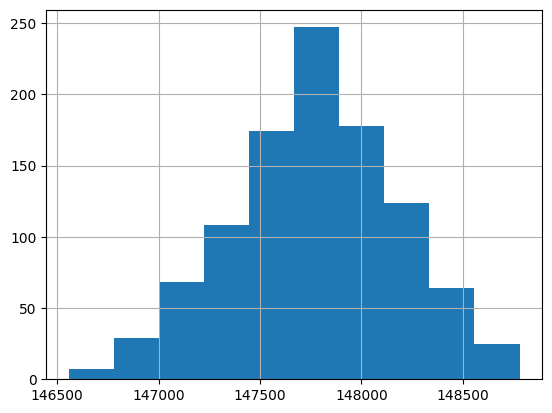

In [148]:
saved_steps_df[saved_steps_df['mi'] == 1/4]['chosen_sample']["['A' 'F'] count_order"].hist()

In [149]:
if ('mean' in OUTPUT_COLS):
    print("Mean of chosen_sample['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['chosen_sample']['mean'].hist()

In [150]:
if ('mean' in OUTPUT_COLS):
    print("Mean of release['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['release']['mean'].hist()

In [110]:
### DEBUG: Save the variables from computing the PAC noises for later reverse engineering
#if GENERATE:
#    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['mi', 'out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
#    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
#else:
#    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
#saved_pac_variables_df.head()

### Computing PAC Errors

In [160]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [161]:
#OUTPUT_COLS = OUTPUT_COLS
ERROR_COLS = [*[f'absolute error {i}' for i in flattened_output_cols], *[f'relative error {i}' for i in flattened_output_cols]]

In [162]:
df.to_pandas()

,mi,['A' 'F'] sum_qty,['A' 'F'] sum_base_price,['A' 'F'] sum_disc_price,['A' 'F'] sum_charge,['A' 'F'] avg_qty,['A' 'F'] avg_price,['A' 'F'] avg_disc,['A' 'F'] count_order,['N' 'F'] sum_qty,...,['N' 'O'] avg_disc,['N' 'O'] count_order,['R' 'F'] sum_qty,['R' 'F'] sum_base_price,['R' 'F'] sum_disc_price,['R' 'F'] sum_charge,['R' 'F'] avg_qty,['R' 'F'] avg_price,['R' 'F'] avg_disc,['R' 'F'] count_order
0,0.015625,-1.030738e+07,5.550604e+09,4.615739e+09,5.876578e+09,-29270.965821,-512857.891468,874.593043,9.637476e+05,-1.580272e+06,...,551.323609,-3.034465e+05,-3.145895e+05,5.093621e+09,5.053366e+09,5.018984e+09,8476.571942,286956.297758,1463.637879,-1.239256e+06
1,0.015625,-1.232548e+07,5.489424e+09,5.210863e+09,4.956002e+09,34812.592850,475502.004759,-346.386619,1.050423e+05,1.545879e+06,...,-372.849583,7.814261e+05,1.526804e+06,5.539800e+09,4.883731e+09,5.096860e+09,6794.276498,214129.370456,-1301.845379,-5.593531e+05
2,0.015625,3.540351e+06,4.984569e+09,5.245219e+09,5.453591e+09,-21578.564525,-469344.910745,-364.191330,1.402775e+06,-5.482217e+06,...,442.151872,-2.163651e+06,-9.497068e+05,5.299338e+09,5.372183e+09,5.693902e+09,14268.392249,202445.840137,176.904980,3.602242e+06
3,0.015625,-1.314804e+06,4.798404e+09,4.778205e+09,5.900839e+09,749.434965,-334877.541366,385.309084,8.506814e+05,-6.385803e+06,...,561.669322,-1.494085e+06,-1.411147e+06,5.753650e+09,4.876200e+09,5.070943e+09,-3748.184760,150134.815447,-141.550810,2.775038e+06
4,0.015625,1.462219e+05,5.431874e+09,5.187772e+09,5.052014e+09,9073.823940,92332.962015,326.354440,-3.162186e+05,-5.770174e+06,...,-137.982604,3.605539e+05,7.697322e+06,4.797866e+09,5.409965e+09,5.113619e+09,16342.187776,264383.075137,442.913119,2.289227e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,16.000000,3.848445e+06,5.334125e+09,5.077306e+09,5.293092e+09,391.583921,41936.739245,-35.405695,1.223181e+05,1.308494e+05,...,-5.048000,1.989978e+05,3.964084e+06,5.352033e+09,5.082984e+09,5.291475e+09,17.528162,34016.791830,-27.809534,2.645033e+05
8188,16.000000,3.348035e+06,5.335005e+09,5.045745e+09,5.252634e+09,211.753082,25952.664110,5.896086,2.478018e+05,3.127249e+04,...,-13.471610,2.550730e+05,3.995860e+06,5.348519e+09,5.067960e+09,5.262837e+09,541.585105,32520.575779,5.417333,1.448626e+05
8189,16.000000,3.536748e+06,5.299129e+09,5.051690e+09,5.245739e+09,46.110574,-882.409424,19.862708,1.396419e+05,-7.212268e+03,...,-3.526804,3.013150e+05,3.761070e+06,5.333435e+09,5.099246e+09,5.286703e+09,715.605795,30115.416478,-1.811968,1.432153e+05
8190,16.000000,3.620785e+06,5.294427e+09,5.031456e+09,5.225118e+09,298.449027,57502.959276,0.899663,1.410908e+05,1.071007e+05,...,6.705774,2.227871e+05,3.772594e+06,5.346446e+09,5.077990e+09,5.277848e+09,-312.664231,40164.185654,-19.032530,2.028995e+05


In [163]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.to_pandas().iterrows():
        mi = row['mi']
        r = row[flattened_output_cols].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

,mi,absolute error ['A' 'F'] sum_qty,absolute error ['A' 'F'] sum_base_price,absolute error ['A' 'F'] sum_disc_price,absolute error ['A' 'F'] sum_charge,absolute error ['A' 'F'] avg_qty,absolute error ['A' 'F'] avg_price,absolute error ['A' 'F'] avg_disc,absolute error ['A' 'F'] count_order,absolute error ['N' 'F'] sum_qty,...,relative error ['N' 'O'] avg_disc,relative error ['N' 'O'] count_order,relative error ['R' 'F'] sum_qty,relative error ['R' 'F'] sum_base_price,relative error ['R' 'F'] sum_disc_price,relative error ['R' 'F'] sum_charge,relative error ['R' 'F'] avg_qty,relative error ['R' 'F'] avg_price,relative error ['R' 'F'] avg_disc,relative error ['R' 'F'] count_order
0,0.015625,1.408158e+07,2.298500e+08,4.383569e+08,6.198271e+08,29296.503408,548860.015297,874.542899,8.159576e+05,1.675529e+06,...,1.100435e+06,203.920018,108.310330,4.577215,0.363827,4.842653,33107.672906,697.233052,2.927804e+06,935.635311
1,0.015625,1.609968e+07,1.686703e+08,1.567664e+08,3.007490e+08,34787.055263,439499.880930,346.436764,4.274766e+04,1.450622e+06,...,7.443708e+05,167.611666,59.667291,3.781396,3.708487,3.366170,26517.141116,494.902474,2.604349e+06,477.174165
2,0.015625,2.338489e+05,3.361853e+08,1.911231e+08,1.968392e+08,21604.102112,505347.034574,364.241474,1.254985e+06,5.577474e+06,...,8.825099e+05,840.976292,125.087863,0.723361,5.922226,7.953430,55797.608837,462.442840,3.537858e+05,2329.007372
3,0.015625,5.089004e+06,5.223499e+08,2.758918e+08,6.440872e+08,723.897378,370879.665195,385.258939,7.028914e+05,6.481060e+06,...,1.121087e+06,611.672946,137.277455,7.787625,3.856979,3.857551,14783.824352,317.110334,2.832623e+05,1771.220268
4,0.015625,3.627978e+06,1.111201e+08,1.336760e+08,2.047373e+08,9048.286352,56330.838186,326.304295,4.640086e+05,5.865431e+06,...,2.755366e+05,23.477347,103.335767,10.117826,6.667172,3.048421,63921.874635,634.519255,8.859162e+05,1443.635364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,16.000000,7.424471e+04,1.337088e+07,2.320967e+07,3.634067e+07,366.046334,5934.615416,35.455840,2.547186e+04,3.559238e+04,...,1.017666e+04,31.850071,4.716950,0.263821,0.220155,0.323622,31.331972,5.493237,5.573100e+04,78.355731
8188,16.000000,4.261646e+05,1.425094e+07,8.350853e+06,4.117024e+06,186.215495,10049.459719,5.845942,1.000118e+05,6.398451e+04,...,2.699161e+04,12.646224,5.556362,0.197986,0.076074,0.219329,2021.704523,9.650082,1.073699e+04,2.318520
8189,16.000000,2.374516e+05,2.162501e+07,2.406561e+06,1.101246e+07,20.572987,36884.533253,19.812564,8.148095e+03,1.024693e+05,...,7.140097e+03,3.190070,0.645962,0.084585,0.540778,0.233154,2703.444993,16.332189,3.724713e+03,3.429310
8190,16.000000,1.534147e+05,2.632661e+07,2.263983e+07,3.163374e+07,272.911440,21500.835447,0.849519,6.699219e+03,1.184366e+04,...,1.328586e+04,23.703062,0.341530,0.159144,0.121680,0.065259,1324.888030,11.585689,3.817322e+04,36.816036


In [164]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Computing DP Errors

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [165]:
dp_results_df = pq.read_table(f"./outputs/chorus-q1/dp_results.parquet").to_pandas()

# compute sum from count and mean
dp_results_df = dp_results_df[['mi', 'count_order']]

# filter to just MI_OPTIONS
dp_results_df = dp_results_df[dp_results_df['mi'].isin(MI_OPTIONS)]

dp_results_df

,mi,count_order
0,0.015625,147791.309165
1,0.015625,147794.546580
2,0.015625,147792.947742
3,0.015625,147814.626133
4,0.015625,147784.789309
...,...,...
7995,16.000000,147790.175168
7996,16.000000,147790.163717
7997,16.000000,147790.253677
7998,16.000000,147789.720870


In [167]:
GENERATE_DP = False
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        mi = row['mi']
        r = row[flattened_output_cols].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    dp_errors_df.to_parquet(f"./outputs/chorus-q1/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"./outputs/chorus-q1/dp_errors.parquet").to_pandas()
dp_errors_df

,mi,absolute error count_order,relative error count_order
0,0.015625,1.309165,0.000886
1,0.015625,4.546580,0.003076
2,0.015625,2.947742,0.001995
3,0.015625,24.626133,0.016663
4,0.015625,5.210691,0.003526
...,...,...,...
7995,16.000000,0.175168,0.000119
7996,16.000000,0.163717,0.000111
7997,16.000000,0.253677,0.000172
7998,16.000000,0.279130,0.000189


In [169]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}), # switch from eps to mi for indexing DP results
    #dp_results_df.assign(type='dp').rename(columns={'mi': 'factor'}), # comment out DP results until we have some
    df.to_pandas().assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")  # Save the merged results
all_df

['A' 'F'] sum_qty mean  ['A' 'F'] sum_qty var  \
type factor                                                     
pac  0.015625             3.859206e+06           5.999951e+13   
     0.031250             3.848080e+06           3.158015e+13   
     0.062500             3.864008e+06           1.648821e+13   
     0.250000             3.811822e+06           3.833243e+12   
     1.000000             3.779612e+06           1.052902e+12   
     2.000000             3.805744e+06           5.063098e+11   
     4.000000             3.787948e+06           2.598881e+11   
     16.000000            3.762685e+06           6.189636e+10   

                ['A' 'F'] sum_base_price mean  ['A' 'F'] sum_base_price var  \
type factor                                                                   
pac  0.015625                    5.312713e+09                  8.911701e+16   
     0.031250                    5.325722e+09                  4.561510e+16   
     0.062500                    5.313721e+09                  2.403883e+16   
     0.250000                    5.320183e+09                  6.373516e+15   
     1.000000                    5.319040e+09                  1.745559e+15   
     2.000000                    5.320326e+09                  1.101130e+15   
     4.000000                    5.320040e+09                  6.499862e+14   
     16.000000                   5.320457e+09                  3.950576e+14   

                ['A' 'F'] sum_disc_price mean  ['A' 'F'] sum_disc_price var  \
type factor                                                                   
pac  0.015625                    5.041640e+09                  9.493273e+16   
     0.031250                    5.047562e+09                  4.311656e+16   
     0.062500                    5.054814e+09                  2.102564e+16   
     0.250000                    5.061272e+09                  5.684297e+15   
     1.000000                    5.054398e+09                  1.685071e+15   
     2.000000                    5.054284e+09                  9.650252e+14   
     4.000000                    5.053830e+09                  6.071290e+14   
     16.000000                   5.053444e+09                  3.314745e+14   

                ['A' 'F'] sum_charge mean  ['A' 'F'] sum_charge var  \
type factor                                                           
pac  0.015625                5.256986e+09              9.985482e+16   
     0.031250                5.272554e+09              4.569299e+16   
     0.062500                5.252194e+09              2.327764e+16   
     0.250000                5.258152e+09              5.936928e+15   
     1.000000                5.258859e+09              1.840746e+15   
     2.000000                5.257227e+09              1.051150e+15   
     4.000000                5.255162e+09              6.234966e+14   
     16.000000               5.256337e+09              3.830175e+14   

                ['A' 'F'] avg_qty mean  ['A' 'F'] avg_qty var  ...  \
type factor                                                    ...   
pac  0.015625              -450.163736           2.105780e+08  ...   
     0.031250              -510.795149           1.061507e+08  ...   
     0.062500               114.648377           5.204195e+07  ...   
     0.250000                -1.113955           1.220085e+07  ...   
     1.000000               -59.832429           3.422508e+06  ...   
     2.000000                18.412446           1.495195e+06  ...   
     4.000000                37.597775           8.262665e+05  ...   
     16.000000               23.356468           1.998872e+05  ...   

                ['R' 'F'] sum_charge mean  ['R' 'F'] sum_charge var  \
type factor                                                           
pac  0.015625                5.285719e+09              9.495920e+16   
     0.031250                5.286014e+09              4.516793e+16   
     0.062500                5.280138e+09              2.330184e+16   
     0.250000   

In [170]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), # switch from eps to mi for indexing DP results
    #dp_errors_df.assign(type='dp').rename(columns={'mi': 'factor'}), # comment out DP results until we have some
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
#errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

#errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error ['A' 'F'] sum_qty mean  \
type factor                                             
pac  0.015625                            6.189530e+06   
     0.031250                            4.514121e+06   
     0.062500                            3.265871e+06   
     0.250000                            1.558383e+06   
     1.000000                            8.159097e+05   
     2.000000                            5.610357e+05   
     4.000000                            4.044360e+05   
     16.000000                           2.006533e+05   

                absolute error ['A' 'F'] sum_qty var  \
type factor                                            
pac  0.015625                           2.165901e+13   
     0.031250                           1.118841e+13   
     0.062500                           5.819937e+12   
     0.250000                           1.403727e+12   
     1.000000                           3.865717e+11   
     2.000000                           1.922370e+11   
     4.000000                           9.634892e+10   
     16.000000                          2.172798e+10   

                absolute error ['A' 'F'] sum_base_price mean  \
type factor                                                    
pac  0.015625                                   2.415407e+08   
     0.031250                                   1.705360e+08   
     0.062500                                   1.245161e+08   
     0.250000                                   6.383355e+07   
     1.000000                                   3.331985e+07   
     2.000000                                   2.651740e+07   
     4.000000                                   2.027248e+07   
     16.000000                                  1.606677e+07   

                absolute error ['A' 'F'] sum_base_price var  \
type factor                                                   
pac  0.015625                                  3.078280e+16   
     0.031250                                  1.652884e+16   
     0.062500                                  8.568915e+15   
     0.250000                                  2.295137e+15   
     1.000000                                  6.372031e+14   
     2.000000                                  3.974528e+14   
     4.000000                                  2.391208e+14   
     16.000000                                 1.367524e+14   

                absolute error ['A' 'F'] sum_disc_price mean  \
type factor                                                    
pac  0.015625                                   2.434843e+08   
     0.031250                                   1.673490e+08   
     0.062500                                   1.147001e+08   
     0.250000                                   6.079600e+07   
     1.000000                                   3.228775e+07   
     2.000000                                   2.455790e+07   
     4.000000                                   1.968853e+07   
     16.000000                                  1.446443e+07   

                absolute error ['A' 'F'] sum_disc_price var  \
type factor                                                   
pac  0.015625                                  3.574550e+16   
     0.031250                                  1.512624e+16   
     0.062500                                  7.857191e+15   
     0.250000                                  2.036069e+15   
     1.000000                                  6.416434e+14   
     2.000000                                  3.613804e+14   
     4.000000                                  2.191827e+14   
     16.000000                                 1.224765e+14   

                absolute error ['A' 'F'] sum_charge mean  \
type factor                                                
pac  0.015625                               2.512279e+08   
     0.031250                               1.714178e+08   
     0.062500                               1.214857e+08   
     0.250000                           

In [171]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [172]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [173]:
import matplotlib.colors as mcolors

PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# Function to lighten a color by blending with white
def lighten_color(color, amount=0.3):
    rgba = mcolors.to_rgba(color)
    return tuple(np.clip(np.array(rgba[:3]) + amount, 0, 1)) + (rgba[3],)

# Create lighter colors
PAC_LIGHT = lighten_color(PAC_COLOR, 0.3)
DP_LIGHT = lighten_color(DP_COLOR, 0.3)

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

IndexError: index 2 is out of bounds for axis 0 with size 2

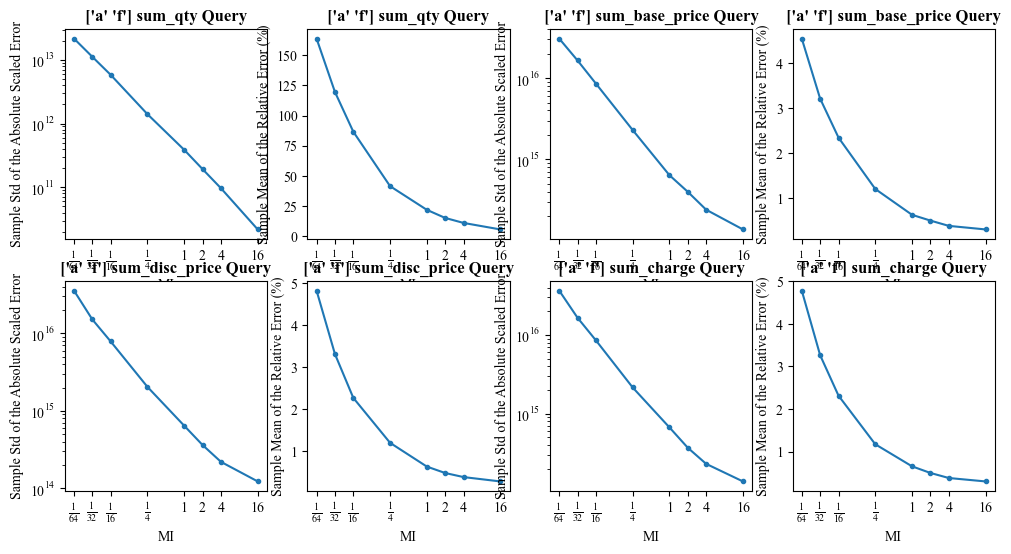

In [175]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = flattened_output_cols
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')

    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.95, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

KeyError: 'dp'

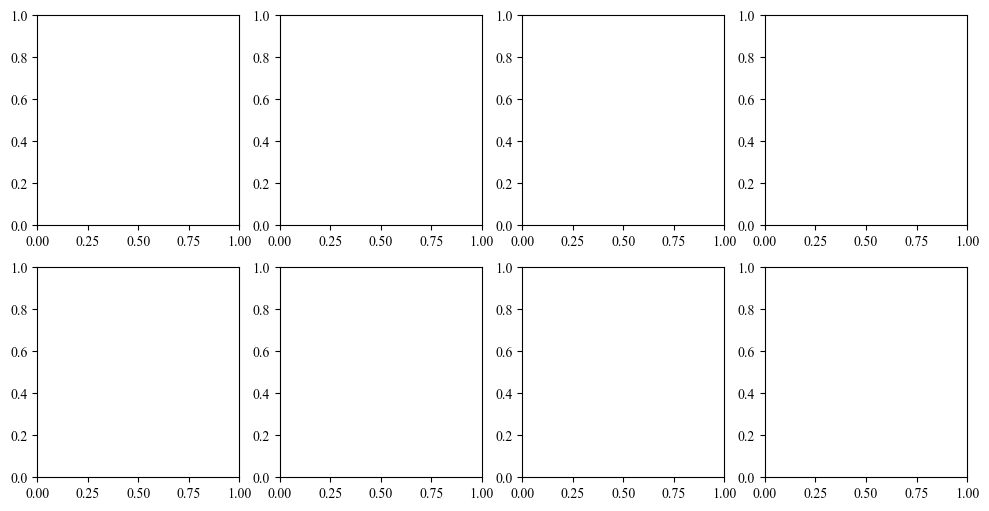

In [177]:
### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = flattened_output_cols
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    
    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

Both on the same axes, aligned

KeyError: 'dp'

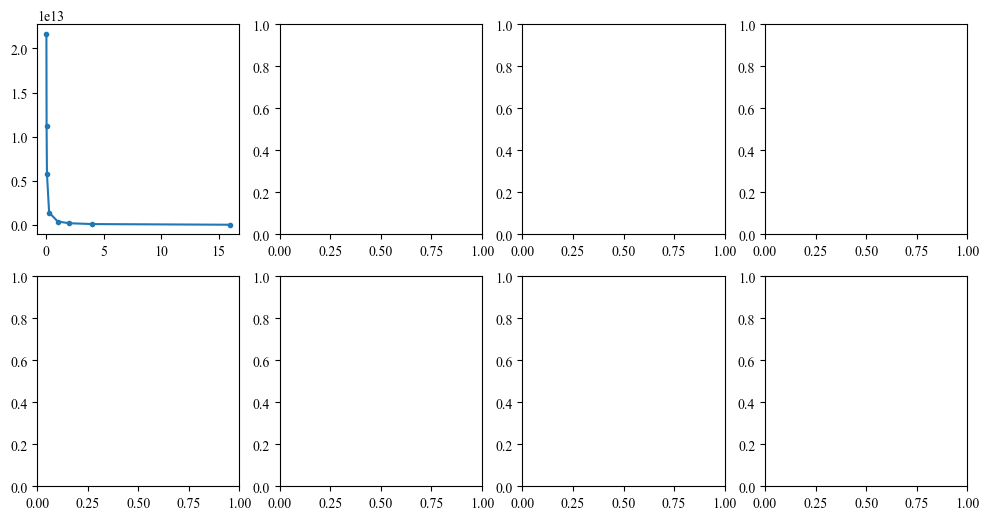

In [178]:
### Both on the same axes, aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = flattened_output_cols
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    #print(d)
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('MI')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    
    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('MI')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

# Additonal Extra Plotting

IndexError: index 2 is out of bounds for axis 0 with size 2

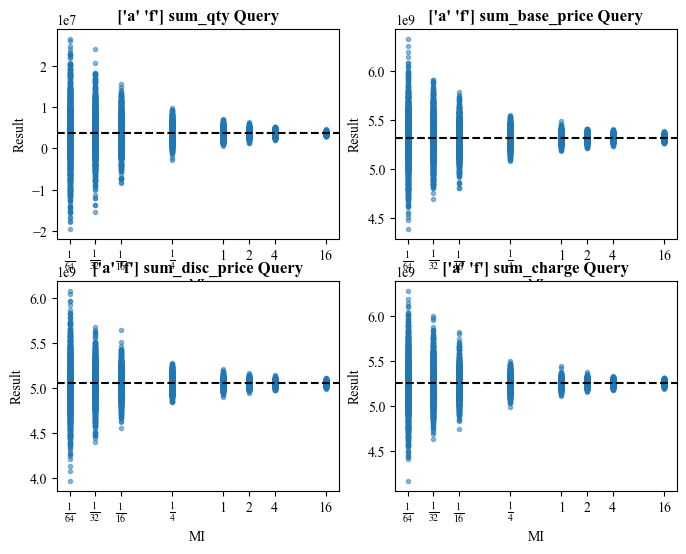

In [179]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = flattened_output_cols
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

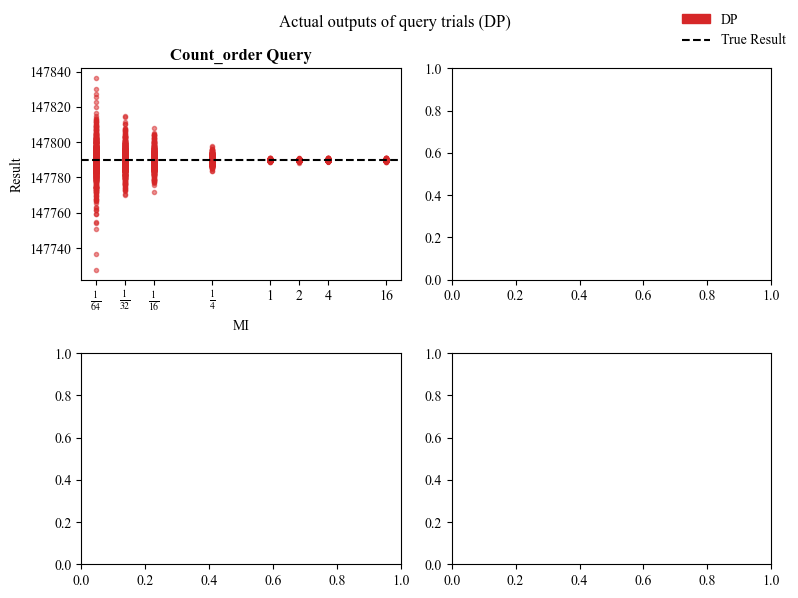

In [72]:
### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'dp'

    ax.scatter(dp_results_df['mi'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

In [180]:
%%script echo skipping### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = flattened_output_cols
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.linewidth = 0.25

    # correct answer
    ax.axhline(y=true_result[i], color='gray', linestyle='--', label='True Result')

    for mi in MI_OPTIONS: # categorical variable
        position = MI_OPTIONS.index(mi) * 2

        TYPE = 'pac'

        pac_style = {
            'boxprops': dict(facecolor=PAC_LIGHT),
            'medianprops': dict(color='black')
        }
        
        # mi = mi and query is correct
        d = df[df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **pac_style)

        position += 1
        TYPE = 'dp'

        dp_style = {
            'boxprops': dict(facecolor=DP_LIGHT),
            'medianprops': dict(color='black')
        }

        # mi = mi and query is correct
        d = dp_results_df[dp_results_df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **dp_style)
    
    
    
    # override xticks, one for each pair of boxplots
    # the x axis is actually artificial here to plot both PAC and DP side by side
    xticks = [0.5+2*i for i in range(len(MI_OPTIONS))]
    ax.set_xticks(xticks)

    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in MI_OPTIONS]
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='gray', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query trials (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp_vs_pac.jpg", bbox_inches='tight')
plt.show()


skipping### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))


In [183]:
df.to_pandas().groupby('mi').var()

,['A' 'F'] sum_qty,['A' 'F'] sum_base_price,['A' 'F'] sum_disc_price,['A' 'F'] sum_charge,['A' 'F'] avg_qty,['A' 'F'] avg_price,['A' 'F'] avg_disc,['A' 'F'] count_order,['N' 'F'] sum_qty,['N' 'F'] sum_base_price,...,['N' 'O'] avg_disc,['N' 'O'] count_order,['R' 'F'] sum_qty,['R' 'F'] sum_base_price,['R' 'F'] sum_disc_price,['R' 'F'] sum_charge,['R' 'F'] avg_qty,['R' 'F'] avg_price,['R' 'F'] avg_disc,['R' 'F'] count_order
mi,,,,,,,,,,,,,,,,,,,,,
0.015625,5.999951e+13,8.911701e+16,9.493273e+16,9.985482e+16,2.105780e+08,3.397841e+11,445502.646983,2.053833e+12,1.006518e+13,1.438139e+16,...,301272.696612,2.883472e+12,6.627866e+13,9.350436e+16,9.606810e+16,9.495920e+16,1.941212e+08,3.312689e+11,438280.344180,2.077860e+12
0.031250,3.158015e+13,4.561510e+16,4.311656e+16,4.569299e+16,1.061507e+08,1.625185e+11,224464.073863,1.155963e+12,4.626925e+12,7.210822e+15,...,170419.550390,1.441448e+12,3.096635e+13,4.687058e+16,4.273716e+16,4.516793e+16,1.086527e+08,1.627257e+11,230648.991514,1.039784e+12
0.062500,1.648821e+13,2.403883e+16,2.102564e+16,2.327764e+16,5.204195e+07,8.033501e+10,114877.283108,5.287026e+11,2.392694e+12,3.341201e+15,...,79214.681284,7.534190e+11,1.665265e+13,2.476373e+16,2.298589e+16,2.330184e+16,4.834769e+07,7.762589e+10,110665.478293,5.600693e+11
0.250000,3.833243e+12,6.373516e+15,5.684297e+15,5.936928e+15,1.220085e+07,2.196328e+10,27370.996451,1.408527e+11,5.863987e+11,8.142774e+14,...,19933.802229,1.822978e+11,3.998512e+12,6.135438e+15,6.019457e+15,6.503278e+15,1.186804e+07,1.878548e+10,29046.629218,1.427447e+11
1.000000,1.052902e+12,1.745559e+15,1.685071e+15,1.840746e+15,3.422508e+06,5.259685e+09,6710.111463,3.510813e+10,1.575954e+11,2.157723e+14,...,5112.665296,4.657833e+10,9.447679e+11,1.767311e+15,1.846834e+15,1.881867e+15,3.145124e+06,4.763111e+09,7067.026493,3.269015e+10
2.000000,5.063098e+11,1.101130e+15,9.650252e+14,1.051150e+15,1.495195e+06,2.520433e+09,3300.288998,1.582146e+10,7.779364e+10,1.164541e+14,...,2460.695125,2.313344e+10,5.114629e+11,9.599618e+14,9.197056e+14,9.563120e+14,1.696116e+06,2.552248e+09,3429.426355,1.741605e+10
4.000000,2.598881e+11,6.499862e+14,6.071290e+14,6.234966e+14,8.262665e+05,1.266348e+09,1716.278396,8.565152e+09,3.700374e+10,5.928513e+13,...,1323.414147,1.256328e+10,2.298703e+11,6.694667e+14,5.739116e+14,6.894934e+14,8.473018e+05,1.215280e+09,1919.996480,7.709331e+09
16.000000,6.189636e+10,3.950576e+14,3.314745e+14,3.830175e+14,1.998872e+05,3.206746e+08,431.163060,2.233151e+09,1.025193e+10,2.100549e+13,...,319.830645,2.911515e+09,6.800350e+10,3.999826e+14,3.763447e+14,3.751153e+14,1.943695e+05,3.078214e+08,445.039990,2.196563e+09


In [184]:
# tables
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap

In [185]:
print("Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)")
saved_steps_df[['mi','scale']].groupby('mi').mean()

Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)


step                  scale                                                    \
query     ['A' 'F'] sum_qty ['A' 'F'] sum_base_price ['A' 'F'] sum_disc_price   
mi                                                                              
0.015625       8.064152e+06             3.080145e+08             3.002349e+08   
0.031250       5.702217e+06             2.177991e+08             2.122981e+08   
0.062500       4.032076e+06             1.540072e+08             1.501174e+08   
0.250000       2.016038e+06             7.700362e+07             7.505872e+07   
1.000000       1.008019e+06             3.850181e+07             3.752936e+07   
2.000000       7.127771e+05             2.722489e+07             2.653727e+07   
4.000000       5.040095e+05             1.925091e+07             1.876468e+07   
16.000000      2.520048e+05             9.625453e+06             9.382340e+06   

step                                                                  \
query     ['A' 'F'] sum_charge ['A' 'F'] avg_qty ['A' 'F'] avg_price   
mi                                                                     
0.015625          3.062961e+08      14531.740882       572893.894506   
0.031250          2.165840e+08      10275.492520       405097.157706   
0.062500          1.531480e+08       7265.870441       286446.947253   
0.250000          7.657401e+07       3632.935221       143223.473627   
1.000000          3.828701e+07       1816.467610        71611.736813   
2.000000          2.707300e+07       1284.436565        50637.144713   
4.000000          1.914350e+07        908.233805        35805.868407   
16.000000         9.571752e+06        454.116903        17902.934203   

step                                                                  \
query     ['A' 'F'] avg_disc ['A' 'F'] count_order ['N' 'F'] sum_qty   
mi                                                                     
0.015625          672.028398          1.475560e+06      3.116589e+06   
0.031250          475.195837          1.043378e+06      2.203761e+06   
0.062500          336.014199          7.377800e+05      1.558294e+06   
0.250000          168.007099          3.688900e+05      7.791472e+05   
1.000000           84.003550          1.844450e+05      3.895736e+05   
2.000000           59.399480          1.304223e+05      2.754701e+05   
4.000000           42.001775          9.222250e+04      1.947868e+05   
16.000000          21.000887          4.611125e+04      9.739340e+04   

step                                ...                     \
query     ['N' 'F'] sum_base_price  ... ['N' 'O'] avg_disc   
mi                                  ...                      
0.015625              1.177807e+08  ...         565.033826   
0.031250              8.328355e+07  ...         399.539250   
0.062500              5.889036e+07  ...         282.516913   
0.250000              2.944518e+07  ...         141.258456   
1.000000              1.472259e+07  ...          70.629228   
2.000000              1.041044e+07  ...          49.942406   
4.000000              7.361296e+06  ...          35.314614   
16.000000             3.680648e+06  ...          17.657307   

step                                                                        \
query     ['N' 'O'] count_order ['R' 'F'] sum_qty ['R' 'F'] sum_base_price   
mi                                                                           
0.015625           1.724210e+06      8.074915e+06             3.067639e+08   
0.031250           1.219201e+06      5.709827e+06             2.169148e+08   
0.062500           8.621052e+05      4.037457e+06             1.533819e+08   
0.250000           4.310526e+05      2.018729e+06             7.669097e+07   
1.000000           2.155263e+05      1.009364e+06             3.834548e+07   
2.000000           1.524001e+05      7.137284e+05             2.711435e+07   
4.000000           1.077631e+05      5.046822e+05             1.917274e+07   
16.000000          5.388157e+04      2.523411e+05          

Comparison of how much noise is added to the data, by looking at the variance of the distributions from which noise is sampled.

In [186]:
%%script echo skipping # Wait until we have DP data to compare
dp_var_noise = {  # from pipelinedp repo, dp_basic_mean_variances.csv
    #0.00390625: 0.2784089313555703,
    #0.0078125: 0.19648087910574175,
    0.015625: 0.13837628104247293,
    0.0625: 0.06750340282072995,
    0.25: 0.03001721300521553,
    1.0: 0.004282722801885366,
    2.0: 0.004282722801885366,
    4.0: 0.004282722801885366,
    16.0: 0.004282722801885366
}
d = dp_var_noise
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(d.keys(), d.values(), marker='.', label='DP', color=DP_COLOR)
plt.xlabel('MI')
ax.set_xticks(list(d.keys()))
ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
plt.suptitle('Noise added by DP to Mean query (scale param passed to Laplace noise function)')
plt.title('DP')
plt.savefig(f"{OUTPUT_DIR}/noise_distribution_scale_meanquery_dp.jpg", bbox_inches='tight')
plt.show()

skipping # Wait until we have DP data to compare


In [187]:
#assert not any(any(saved_steps_df[['mi','scale']].groupby('mi').var().values)) # assume we are only computing scale once per MI
if ('mean' in OUTPUT_COLS):
    pac_var_noise = dict(zip(MI_OPTIONS, saved_steps_df[['mi','scale']].groupby('mi').mean()[[('scale','mean')]].to_numpy().flatten()))
    pac_var_noise

In [188]:
# Let's compute the same for PAC: what is the scale of the distribution from which noise is sampled to add to PAC?
if ('mean' in OUTPUT_COLS): 
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    d = pac_var_noise
    plt.plot(d.keys(), d.values(), marker='.', label='PAC', color=PAC_COLOR)
    plt.xlabel('MI')
    ax.set_xticks(list(d.keys()))
    ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
    plt.suptitle('Noise added by PAC to Mean query (scale param passed to Normal noise function)')
    plt.title('PAC')
    plt.savefig(f"{OUTPUT_DIR}/noise_distribution_scale_meanquery_pac.jpg", bbox_inches='tight')
    plt.show()

In [190]:
# How much of PAC error is due to sampling? Compute % error on our samples before noise was added
sample_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()]
sample_errors_df = pd.DataFrame(sample_errors, columns=flattened_output_cols)
sample_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Error from Subsampling (as % of true_result, without any noise being added)")
#print("First output: overall mean / Second output: grouped by MI")
display(sample_errors_df[flattened_output_cols].mean())
display(sample_errors_df.groupby('mi').mean())

PAC: Error from Subsampling (as % of true_result, without any noise being added)


['A' 'F'] sum_qty           0.249807
['A' 'F'] sum_base_price    0.258028
['A' 'F'] sum_disc_price    0.257888
['A' 'F'] sum_charge        0.257995
['A' 'F'] avg_qty           0.118943
['A' 'F'] avg_price         0.130825
['A' 'F'] avg_disc          0.129681
['A' 'F'] count_order       0.213471
['N' 'F'] sum_qty           1.487901
['N' 'F'] sum_base_price    1.508853
['N' 'F'] sum_disc_price    1.507794
['N' 'F'] sum_charge        1.507136
['N' 'F'] avg_qty           0.747257
['N' 'F'] avg_price         0.808380
['N' 'F'] avg_disc          0.795878
['N' 'F'] count_order       1.298167
['N' 'O'] sum_qty           0.164401
['N' 'O'] sum_base_price    0.166432
['N' 'O'] sum_disc_price    0.166871
['N' 'O'] sum_charge        0.166787
['N' 'O'] avg_qty           0.080641
['N' 'O'] avg_price         0.086237
['N' 'O'] avg_disc          0.092719
['N' 'O'] count_order       0.146349
['R' 'F'] sum_qty           0.247363
['R' 'F'] sum_base_price    0.252923
['R' 'F'] sum_disc_price    0.253435
[

,['A' 'F'] sum_qty,['A' 'F'] sum_base_price,['A' 'F'] sum_disc_price,['A' 'F'] sum_charge,['A' 'F'] avg_qty,['A' 'F'] avg_price,['A' 'F'] avg_disc,['A' 'F'] count_order,['N' 'F'] sum_qty,['N' 'F'] sum_base_price,...,['N' 'O'] avg_disc,['N' 'O'] count_order,['R' 'F'] sum_qty,['R' 'F'] sum_base_price,['R' 'F'] sum_disc_price,['R' 'F'] sum_charge,['R' 'F'] avg_qty,['R' 'F'] avg_price,['R' 'F'] avg_disc,['R' 'F'] count_order
mi,,,,,,,,,,,,,,,,,,,,,
0.015625,0.249795,0.259796,0.259494,0.259511,0.123904,0.136788,0.128024,0.206889,1.447232,1.482352,...,0.098257,0.146751,0.248326,0.254848,0.255279,0.255304,0.118745,0.126637,0.127506,0.208448
0.031250,0.256677,0.262225,0.262302,0.262476,0.120553,0.129684,0.128888,0.220345,1.538584,1.569987,...,0.093536,0.150277,0.246350,0.253361,0.253356,0.253302,0.119801,0.127803,0.130751,0.207173
0.062500,0.247939,0.254966,0.255101,0.255265,0.118526,0.129739,0.128854,0.212243,1.478137,1.490162,...,0.089038,0.144498,0.246599,0.253685,0.254218,0.254079,0.119558,0.127553,0.131701,0.209977
0.250000,0.248989,0.256579,0.256613,0.257025,0.118077,0.131266,0.128920,0.220002,1.463172,1.487976,...,0.088185,0.148426,0.250341,0.253212,0.253891,0.253212,0.113540,0.120825,0.125841,0.210644
1.000000,0.246170,0.253590,0.253098,0.253549,0.116353,0.127706,0.131219,0.210407,1.517822,1.509884,...,0.094670,0.147343,0.244886,0.250072,0.250935,0.250798,0.113289,0.122210,0.127576,0.210935
2.000000,0.252810,0.260695,0.260375,0.260215,0.117177,0.129716,0.131891,0.218000,1.487788,1.515910,...,0.094739,0.141582,0.239025,0.245566,0.245920,0.245960,0.115448,0.123139,0.124496,0.207632
4.000000,0.251121,0.260527,0.260640,0.260167,0.117836,0.130208,0.129175,0.214249,1.465815,1.492657,...,0.092005,0.145369,0.249391,0.255464,0.256134,0.256028,0.114604,0.123185,0.123316,0.212577
16.000000,0.244955,0.255849,0.255483,0.255754,0.119121,0.131491,0.130482,0.205631,1.504655,1.521898,...,0.091321,0.146543,0.253990,0.257174,0.257747,0.257724,0.110711,0.121448,0.131123,0.219562


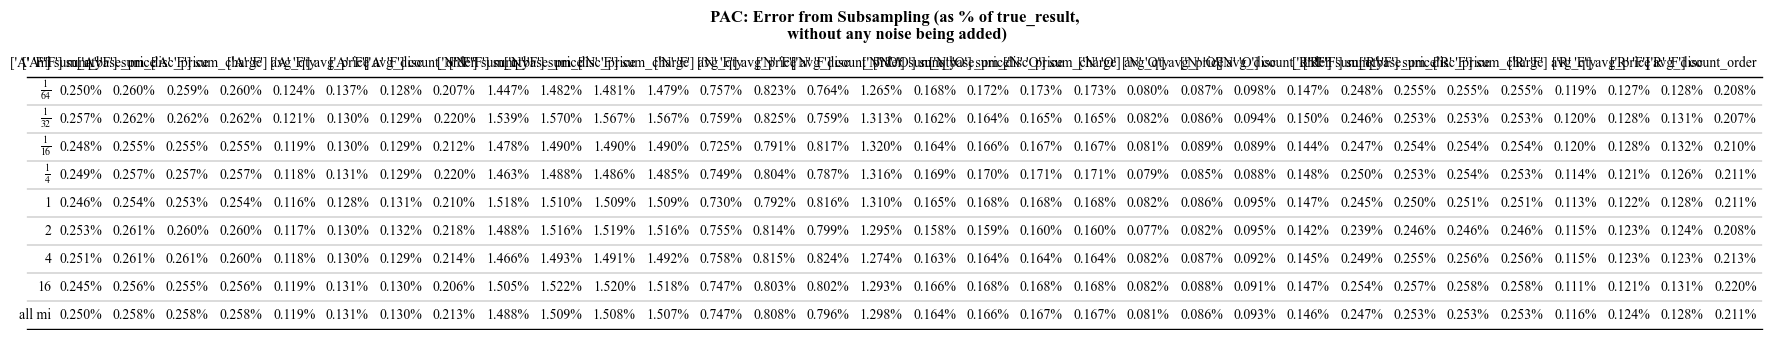

In [191]:
d=sample_errors_df.groupby('mi').mean()
d.loc['all mi'] = sample_errors_df[flattened_output_cols].mean()

fig, ax = plt.subplots(figsize=(2+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: Error from Subsampling (as % of true_result,\n without any noise being added)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_sample_error.jpg", bbox_inches='tight')
plt.show()

In [192]:
print("PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)")
# abs before mean
saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)


/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_32199/2429859456.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


step      abs(chosen_noise)                                                    \
query     ['A' 'F'] sum_qty ['A' 'F'] sum_base_price ['A' 'F'] sum_disc_price   
mi                                                                              
0.015625       6.189262e+06             2.402049e+08             2.425436e+08   
0.031250       4.514283e+06             1.693887e+08             1.662608e+08   
0.062500       3.266211e+06             1.239578e+08             1.139800e+08   
0.250000       1.558087e+06             6.206017e+07             5.905883e+07   
1.000000       8.156947e+05             2.988629e+07             2.993606e+07   
2.000000       5.610090e+05             2.238257e+07             2.078501e+07   
4.000000       4.034673e+05             1.504038e+07             1.486000e+07   
16.000000      2.001051e+05             7.642554e+06             7.493389e+06   

step                                                                  \
query     ['A' 'F'] sum_charge ['A' 'F'] avg_qty ['A' 'F'] avg_price   
mi                                                                     
0.015625          2.511797e+08      11424.380383       461442.357150   
0.031250          1.709456e+08       8270.528181       320356.370123   
0.062500          1.200651e+08       5652.965653       225137.472557   
0.250000          5.952348e+07       2768.298471       119264.542242   
1.000000          3.125677e+07       1477.149010        57973.022506   
2.000000          2.199721e+07        975.691595        39896.700456   
4.000000          1.438489e+07        733.692765        28546.071704   
16.000000         7.537989e+06        359.109901        14372.117978   

step                                                                  \
query     ['A' 'F'] avg_disc ['A' 'F'] count_order ['N' 'F'] sum_qty   
mi                                                                     
0.015625          533.248670          1.139705e+06      2.525995e+06   
0.031250          381.330304          8.530475e+05      1.719281e+06   
0.062500          272.166924          5.797685e+05      1.240627e+06   
0.250000          131.634512          2.976695e+05      6.027978e+05   
1.000000           65.974461          1.510561e+05      3.161036e+05   
2.000000           45.747874          9.968769e+04      2.221554e+05   
4.000000           33.014963          7.491115e+04      1.538205e+05   
16.000000          16.280508          3.819731e+04      7.977977e+04   

step                                ...                     \
query     ['N' 'F'] sum_base_price  ... ['N' 'O'] avg_disc   
mi                                  ...                      
0.015625              9.747539e+07  ...         436.226191   
0.031250              6.733088e+07  ...         329.803057   
0.062500              4.569934e+07  ...         225.163862   
0.250000              2.291327e+07  ...         113.709067   
1.000000              1.164612e+07  ...          57.099111   
2.000000              8.250533e+06  ...          39.655078   
4.000000              5.785113e+06  ...          28.842030   
16.000000             2.958796e+06  ...          14.139266   

step                                                                        \
query     ['N' 'O'] count_order ['R' 'F'] sum_qty ['R' 'F'] sum_base_price   
mi                                                                           
0.015625           1.368559e+06      6.559090e+06             2.441344e+08   
0.031250           9.534298e+05      4.437711e+06             1.730986e+08   
0.062500           6.892145e+05      3.276182e+06             1.232210e+08   
0.250000           3.387173e+05      1.605895e+06             6.174901e+07   
1.000000           1.710074e+05      7.873972e+05             3.097846e+07   
2.000000           1.215107e+05      5.684053e+05             2.115577e+07   
4.000000           8.875567e+04      3.853023e+05             1.554036e+07   
16.000000          4.220973e+04      2.110101e+05          

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_32199/3598423058.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  d = saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


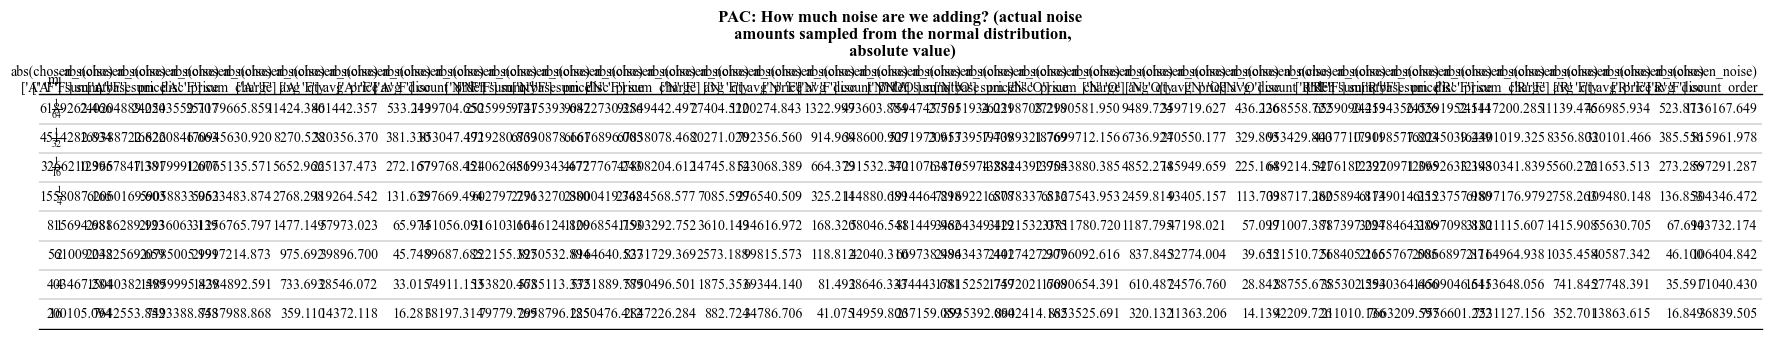

In [193]:
d = saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

fig, ax = plt.subplots(figsize=(2+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        title='\n'.join(c),
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: How much noise are we adding? (actual noise\n amounts sampled from the normal distribution,\n absolute value)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_chosen_noise.jpg", bbox_inches='tight')
plt.show()

In [194]:
print("Avg. value of unnoised sample used by PAC")
display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different
display(saved_steps_df[['chosen_sample']].mean().to_frame(name='all mi').T)  # sample shouldn't change with MI, so we can find the overall average

Avg. value of unnoised sample used by PAC


/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_32199/883409176.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different


step          chosen_sample                                                    \
query     ['A' 'F'] sum_qty ['A' 'F'] sum_base_price ['A' 'F'] sum_disc_price   
mi                                                                              
0.015625       3.774228e+06             5.320728e+09             5.054047e+09   
0.031250       3.773905e+06             5.320307e+09             5.053678e+09   
0.062500       3.773634e+06             5.320156e+09             5.053529e+09   
0.250000       3.773969e+06             5.320273e+09             5.053626e+09   
1.000000       3.774364e+06             5.321026e+09             5.054372e+09   
2.000000       3.774301e+06             5.320752e+09             5.054093e+09   
4.000000       3.773569e+06             5.319832e+09             5.053244e+09   
16.000000      3.773748e+06             5.320239e+09             5.053605e+09   

step                                                                  \
query     ['A' 'F'] sum_charge ['A' 'F'] avg_qty ['A' 'F'] avg_price   
mi                                                                     
0.015625          5.256696e+09         25.538471        36002.921688   
0.031250          5.256314e+09         25.537818        36002.238000   
0.062500          5.256150e+09         25.538642        36004.961714   
0.250000          5.256258e+09         25.537929        36001.554753   
1.000000          5.257040e+09         25.538839        36004.158728   
2.000000          5.256744e+09         25.538480        36002.399892   
4.000000          5.255859e+09         25.537433        36001.675775   
16.000000         5.256231e+09         25.536289        36001.118448   

step                                                                  \
query     ['A' 'F'] avg_disc ['A' 'F'] count_order ['N' 'F'] sum_qty   
mi                                                                     
0.015625            0.050146         147785.957031      95172.740234   
0.031250            0.050142         147777.089844      95162.593750   
0.062500            0.050143         147761.693359      95281.621094   
0.250000            0.050143         147778.964844      95366.912109   
1.000000            0.050140         147789.160156      95238.265625   
2.000000            0.050145         147788.775391      95281.210938   
4.000000            0.050141         147766.162109      95288.214844   
16.000000           0.050145         147779.781250      95318.802734   

step                                ...                     \
query     ['N' 'F'] sum_base_price  ... ['N' 'O'] avg_disc   
mi                                  ...                      
0.015625              1.335997e+08  ...           0.050097   
0.031250              1.335799e+08  ...           0.050099   
0.062500              1.337792e+08  ...           0.050097   
0.250000              1.338920e+08  ...           0.050097   
1.000000              1.337100e+08  ...           0.050096   
2.000000              1.337830e+08  ...           0.050100   
4.000000              1.337842e+08  ...           0.050096   
16.000000             1.338311e+08  ...           0.050098   

step                                                                        \
query     ['N' 'O'] count_order ['R' 'F'] sum_qty ['R' 'F'] sum_base_price   
mi                                                                           
0.015625          291966.326172      3.785829e+06             5.338375e+09   
0.031250          291971.214844      3.786146e+06             5.338749e+09   
0.062500          291995.261719      3.785732e+06             5.338318e+09   
0.250000          291988.685547      3.786036e+06             5.338711e+09   
1.000000          291985.000000      3.786527e+06             5.339568e+09   
2.000000          292006.611328      3.785583e+06             5.338101e+09   
4.000000          291985.535156      3.786192e+06             5.338844e+09   
16.000000         291984.388672      3.785806e+06          

step       chosen_sample                                                    \
query  ['A' 'F'] sum_qty ['A' 'F'] sum_base_price ['A' 'F'] sum_disc_price   
all mi      3.773965e+06             5.320414e+09             5.053774e+09   

step                                                               \
query  ['A' 'F'] sum_charge ['A' 'F'] avg_qty ['A' 'F'] avg_price   
all mi         5.256411e+09         25.537988        36002.628625   

step                                                               \
query  ['A' 'F'] avg_disc ['A' 'F'] count_order ['N' 'F'] sum_qty   
all mi           0.050143         147778.447998      95263.795166   

step                             ...                                           \
query  ['N' 'F'] sum_base_price  ... ['N' 'O'] avg_disc ['N' 'O'] count_order   
all mi             1.337449e+08  ...           0.050097          291985.37793   

step                                                                        \
query  ['R' 'F'] sum_qty ['R' 'F'] sum_base_price ['R' 'F'] sum_disc_price   
all mi      3.785981e+06             5.338624e+09             5.072456e+09   

step                                                               \
query  ['R' 'F'] sum_charge ['R' 'F'] avg_qty ['R' 'F'] avg_price   
all mi         5.275070e+09         25.526003        35994.290949   

step                                             
query  ['R' 'F'] avg_disc ['R' 'F'] count_order  
all mi           0.049988         148318.573486  

[1 rows x 32 columns]

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_32199/1043104497.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  d = saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean()


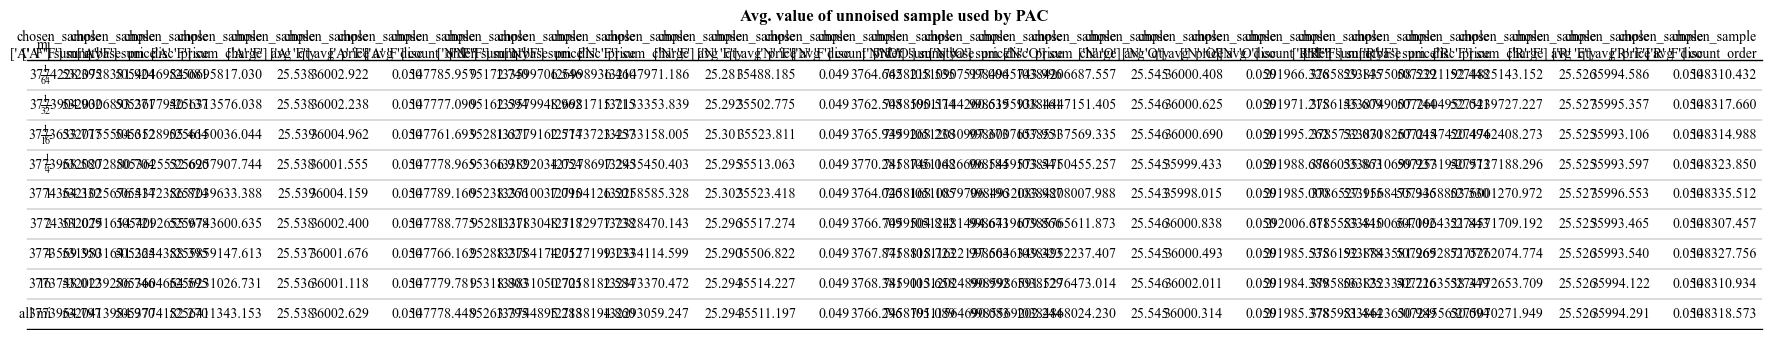

In [195]:
d = saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean()
d.loc['all mi'] = saved_steps_df[['chosen_sample']].mean()

fig, ax = plt.subplots(figsize=(2+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: (f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}') if type(x) != str else x,
    ),
    *[ColumnDefinition(
        name=c,
        title='\n'.join(c),
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("Avg. value of unnoised sample used by PAC")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_unnoised_samples.jpg", bbox_inches='tight')
plt.show()

In [197]:
# How much total error is there in PAC? Compute % error on our samples after noise was added
total_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]
total_errors_df = pd.DataFrame(total_errors, columns=flattened_output_cols)
total_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Total Error (as % of true_result)")
total_errors_df.groupby('mi').mean()

PAC: Total Error (as % of true_result)


,['A' 'F'] sum_qty,['A' 'F'] sum_base_price,['A' 'F'] sum_disc_price,['A' 'F'] sum_charge,['A' 'F'] avg_qty,['A' 'F'] avg_price,['A' 'F'] avg_disc,['A' 'F'] count_order,['N' 'F'] sum_qty,['N' 'F'] sum_base_price,...,['N' 'O'] avg_disc,['N' 'O'] count_order,['R' 'F'] sum_qty,['R' 'F'] sum_base_price,['R' 'F'] sum_disc_price,['R' 'F'] sum_charge,['R' 'F'] avg_qty,['R' 'F'] avg_price,['R' 'F'] avg_disc,['R' 'F'] count_order
mi,,,,,,,,,,,,,,,,,,,,,
0.015625,163.995818,4.539595,4.817563,4.779148,44735.551107,1281.705087,1.063422e+06,771.168368,2651.778859,72.834402,...,870781.193778,468.676750,173.267562,4.581043,4.861630,4.654052,43639.815807,1269.613372,1.047971e+06,766.112451
0.031250,119.604698,3.205110,3.311155,3.260907,32385.716742,889.829340,7.604614e+05,577.191956,1804.838893,50.266682,...,658342.635432,326.526224,117.230292,3.251511,3.219616,3.130336,32738.468084,889.321820,7.712781e+05,550.219775
0.062500,86.531484,2.340196,2.269447,2.311042,22135.859876,625.336711,5.427642e+05,392.271050,1302.412844,34.348274,...,449465.121958,236.037486,86.550899,2.343549,2.386092,2.334637,21782.848280,615.797894,5.466897e+05,402.761085
0.250000,41.290431,1.199709,1.202905,1.170832,10840.089963,331.269951,2.625099e+05,201.419480,632.762609,17.168074,...,226982.514115,115.998247,42.414771,1.170620,1.223679,1.201667,10805.725312,304.166436,2.737643e+05,205.222533
1.000000,21.618082,0.626224,0.638843,0.652623,5784.217211,161.022004,1.315684e+05,102.204850,331.853141,8.823537,...,113979.472018,58.563195,20.775938,0.628861,0.681409,0.657280,5546.941577,154.554683,1.354096e+05,96.912073
2.000000,14.865024,0.498377,0.485901,0.497302,3820.610984,110.815745,9.123191e+04,67.461516,233.315457,6.420497,...,79158.234747,41.606456,15.012502,0.464918,0.482388,0.468164,4056.492889,112.761924,9.221998e+04,71.728767
4.000000,10.715807,0.381008,0.389556,0.378770,2872.992030,79.283810,6.583953e+04,50.677626,161.405111,4.626730,...,57573.574046,30.399163,10.164322,0.383464,0.380437,0.397469,2906.235359,77.093169,7.119789e+04,47.897244
16.000000,5.316446,0.301964,0.286192,0.298277,1406.211396,39.918476,3.246712e+04,25.846489,83.697266,2.765943,...,28224.363795,14.451984,5.582085,0.298308,0.306177,0.292196,1381.723839,38.514681,3.370569e+04,24.841754


In [199]:
# How much total error is there in DP? Compute % error on our samples after noise was added
dp_total_errors = [relative_error_percent(s, true_result) for s in dp_results_df['count_order'].to_numpy()]
dp_total_errors_df = pd.DataFrame(dp_total_errors, columns=flattened_output_cols)
dp_total_errors_df.insert(0, 'mi', dp_results_df['mi'].values)  # Insert 'mi' at the beginning
print("DP: Total Error (as % of true_result)")
dp_total_errors_df.groupby('mi').mean()

DP: Total Error (as % of true_result)


,['A' 'F'] sum_qty,['A' 'F'] sum_base_price,['A' 'F'] sum_disc_price,['A' 'F'] sum_charge,['A' 'F'] avg_qty,['A' 'F'] avg_price,['A' 'F'] avg_disc,['A' 'F'] count_order,['N' 'F'] sum_qty,['N' 'F'] sum_base_price,...,['N' 'O'] avg_disc,['N' 'O'] count_order,['R' 'F'] sum_qty,['R' 'F'] sum_base_price,['R' 'F'] sum_disc_price,['R' 'F'] sum_charge,['R' 'F'] avg_qty,['R' 'F'] avg_price,['R' 'F'] avg_disc,['R' 'F'] count_order
mi,,,,,,,,,,,,,,,,,,,,,
0.015625,96.084205,99.997222,99.997076,99.997189,578615.322630,310.503365,2.947274e+08,0.004089,55.148629,99.889493,...,2.950136e+08,49.387010,96.095918,99.997231,99.997086,99.997198,578879.294559,310.595682,2.956432e+08,0.344617
0.031250,96.084198,99.997222,99.997076,99.997189,578616.449145,310.504164,2.947280e+08,0.002704,55.148931,99.889493,...,2.950141e+08,49.386912,96.095910,99.997231,99.997086,99.997198,578880.421587,310.596481,2.956437e+08,0.344423
0.062500,96.084202,99.997222,99.997076,99.997189,578615.747343,310.503666,2.947276e+08,0.001863,55.148743,99.889493,...,2.950138e+08,49.386973,96.095915,99.997231,99.997086,99.997198,578879.719465,310.595983,2.956434e+08,0.344544
0.250000,96.084202,99.997222,99.997076,99.997189,578615.725133,310.503650,2.947276e+08,0.000800,55.148737,99.889493,...,2.950138e+08,49.386975,96.095915,99.997231,99.997086,99.997198,578879.697245,310.595967,2.956434e+08,0.344548
1.000000,96.084203,99.997222,99.997076,99.997189,578615.592131,310.503556,2.947276e+08,0.000113,55.148701,99.889493,...,2.950137e+08,49.386987,96.095916,99.997231,99.997086,99.997198,578879.564183,310.595873,2.956433e+08,0.344571
2.000000,96.084203,99.997222,99.997076,99.997189,578615.587379,310.503552,2.947276e+08,0.000110,55.148700,99.889493,...,2.950137e+08,49.386987,96.095916,99.997231,99.997086,99.997198,578879.559428,310.595870,2.956433e+08,0.344571
4.000000,96.084203,99.997222,99.997076,99.997189,578615.591640,310.503556,2.947276e+08,0.000123,55.148701,99.889493,...,2.950137e+08,49.386987,96.095916,99.997231,99.997086,99.997198,578879.563692,310.595873,2.956433e+08,0.344571
16.000000,96.084203,99.997222,99.997076,99.997189,578615.649072,310.503596,2.947276e+08,0.000120,55.148717,99.889493,...,2.950137e+08,49.386982,96.095916,99.997231,99.997086,99.997198,578879.621149,310.595913,2.956433e+08,0.344561


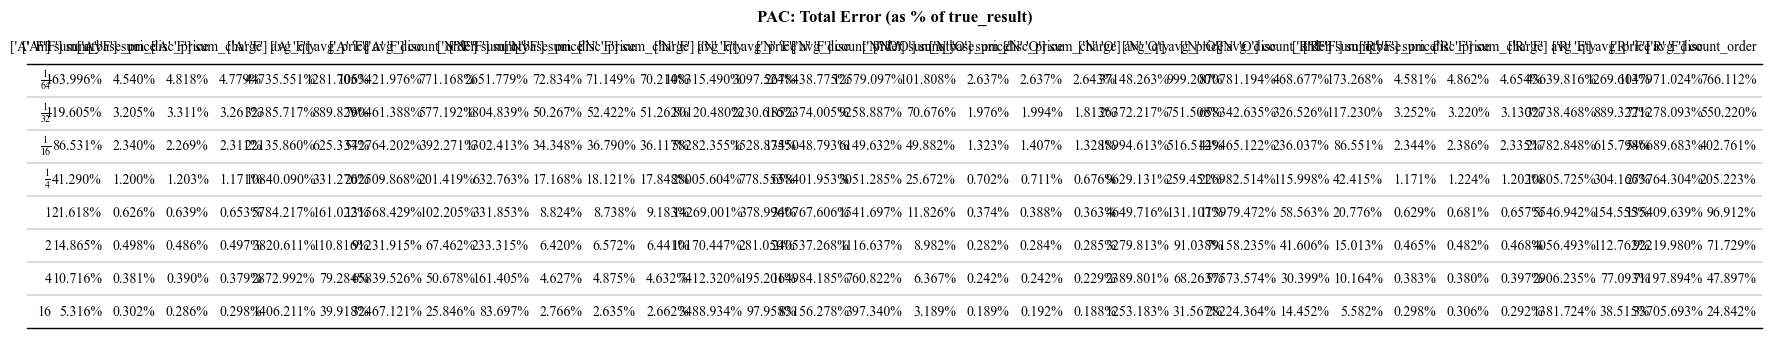

In [200]:
d=total_errors_df.groupby('mi').mean()

fig, ax = plt.subplots(figsize=(2+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    #textprops={"fontsize": 14},
    #row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    #col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    #column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
plt.title("PAC: Total Error (as % of true_result)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_total.jpg", bbox_inches='tight')
plt.show()

In [202]:
print("PAC: Increase in Avg. % error due to noise being added (as % of true_result)")
delta_error_from_noise = pd.concat(
    [
        saved_steps_df['mi'].reset_index(drop=True),
        pd.DataFrame(
            (np.array([relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]) -
             np.array([relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()])),
            columns=flattened_output_cols
        )
    ],
    axis=1
)
delta_error_from_noise.groupby('mi').mean()

PAC: Increase in Avg. % error due to noise being added (as % of true_result)


,['A' 'F'] sum_qty,['A' 'F'] sum_base_price,['A' 'F'] sum_disc_price,['A' 'F'] sum_charge,['A' 'F'] avg_qty,['A' 'F'] avg_price,['A' 'F'] avg_disc,['A' 'F'] count_order,['N' 'F'] sum_qty,['N' 'F'] sum_base_price,...,['N' 'O'] avg_disc,['N' 'O'] count_order,['R' 'F'] sum_qty,['R' 'F'] sum_base_price,['R' 'F'] sum_disc_price,['R' 'F'] sum_charge,['R' 'F'] avg_qty,['R' 'F'] avg_price,['R' 'F'] avg_disc,['R' 'F'] count_order
mi,,,,,,,,,,,,,,,,,,,,,
0.015625,163.746023,4.279799,4.558069,4.519638,44735.427203,1281.568298,1.063422e+06,770.961479,2650.331627,71.352050,...,870781.095522,468.529999,173.019236,4.326195,4.606351,4.398748,43639.697061,1269.486735,1.047971e+06,765.904003
0.031250,119.348021,2.942885,3.048853,2.998431,32385.596189,889.699656,7.604613e+05,576.971611,1803.300309,48.696695,...,658342.541896,326.375947,116.983942,2.998150,2.966260,2.877034,32738.348283,889.194018,7.712780e+05,550.012602
0.062500,86.283545,2.085231,2.014346,2.055777,22135.741350,625.206972,5.427641e+05,392.058807,1300.934707,32.858112,...,449465.032921,235.892988,86.304300,2.089864,2.131874,2.080558,21782.728721,615.670341,5.466896e+05,402.551108
0.250000,41.041442,0.943129,0.946292,0.913807,10839.971886,331.138685,2.625097e+05,201.199478,631.299437,15.680098,...,226982.425930,115.849821,42.164430,0.917408,0.969788,0.948455,10805.611772,304.045611,2.737642e+05,205.011889
1.000000,21.371913,0.372634,0.385745,0.399074,5784.100858,160.894299,1.315683e+05,101.994443,330.335319,7.313653,...,113979.377349,58.415852,20.531052,0.378789,0.430475,0.406482,5546.828288,154.432473,1.354095e+05,96.701139
2.000000,14.612215,0.237681,0.225526,0.237087,3820.493807,110.686029,9.123178e+04,67.243516,231.827669,4.904587,...,79158.140008,41.464874,14.773477,0.219352,0.236468,0.222204,4056.377441,112.638785,9.221986e+04,71.521135
4.000000,10.464686,0.120481,0.128916,0.118603,2872.874194,79.153602,6.583940e+04,50.463377,159.939297,3.134072,...,57573.482041,30.253794,9.914932,0.128001,0.124302,0.141442,2906.120755,76.969984,7.119777e+04,47.684667
16.000000,5.071492,0.046115,0.030709,0.042523,1406.092275,39.786985,3.246699e+04,25.640858,82.192611,1.244045,...,28224.272474,14.305442,5.328095,0.041134,0.048430,0.034472,1381.613128,38.393233,3.370556e+04,24.622192


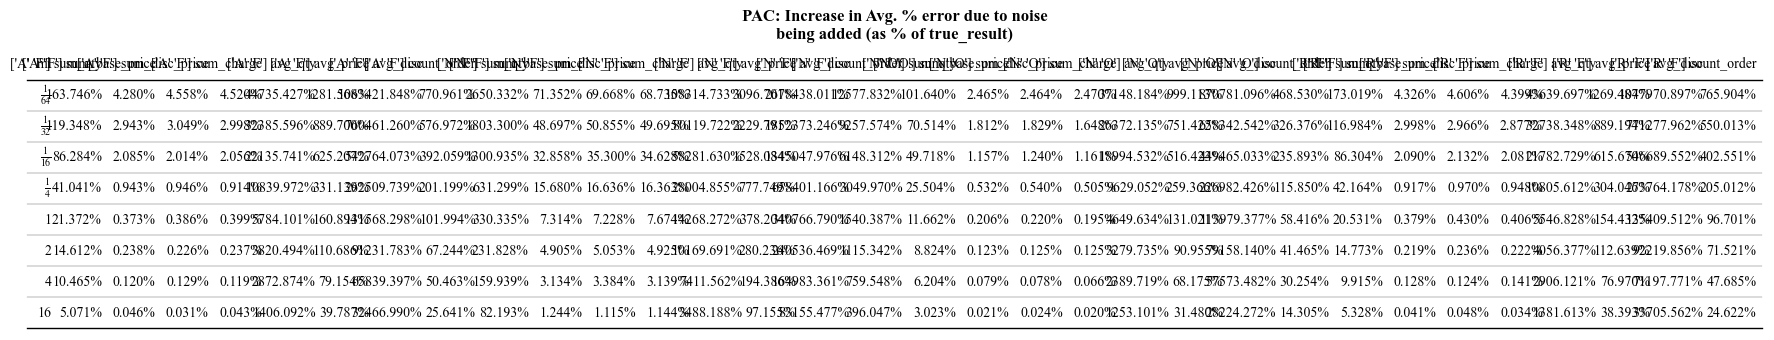

In [203]:
d=delta_error_from_noise.groupby('mi').mean()

fig, ax = plt.subplots(figsize=(2+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns]]
tbl = Table(d,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        )
plt.title("PAC: Increase in Avg. % error due to noise\nbeing added (as % of true_result)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-pac_error_noise.jpg", bbox_inches='tight')
plt.show()

In [204]:
### Combined % Error Table
d = pd.concat([
    sample_errors_df.groupby('mi').mean(),  # % error from subsampling
    delta_error_from_noise.groupby('mi').mean(),  # % error from noise
    total_errors_df.groupby('mi').mean(),  # % total error
    dp_total_errors_df.groupby('mi').mean()  # % DP total error
], axis=1)
d.columns = ['Subsampling', 'Added Noise', 'Total Error', 'Total Error (DP)']

fig, ax = plt.subplots(figsize=(3+(0.5*len(d.columns)), 3.5))

col_defs = [
    ColumnDefinition(
        name=d.index.name,
        #textprops={"ha": "right"},
        width=0.25,
        formatter=lambda x: f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}',
    ),
    *[ColumnDefinition(
        name=c,
        group="PAC",
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.3f}%",
    ) for c in d.columns[:-1]],
    ColumnDefinition(
        name=d.columns[-1],
        textprops={"ha": "right"},
        width=0.5,
        formatter=lambda x: f"{x:.6f}%",
    )]
tbl = Table(d,
            column_definitions=col_defs,
            row_dividers=True,
            footer_divider=True,
            ax=ax,
        )
#plt.title("PAC: Error Breakdown")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/tbl-dp-vs-pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()

ValueError: Length mismatch: Expected axis has 128 elements, new values have 4 elements

IndexError: index 2 is out of bounds for axis 0 with size 2

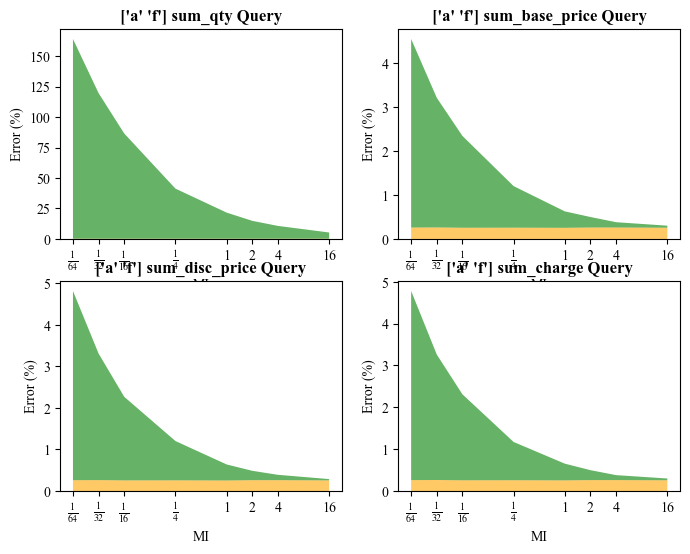

In [206]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

psample_errors = sample_errors_df.groupby('mi').mean()
pnoise_errors = delta_error_from_noise.groupby('mi').mean()

for i, query in enumerate(flattened_output_cols):
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.stackplot(psample_errors.index, psample_errors[query], pnoise_errors[query], 
        labels=['Sample Error', 'Noise Error'], colors=['orange', 'green'], alpha=0.6)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)


    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Error (%)')

fig.legend(handles=[
    Patch(facecolor='orange', edgecolor='orange', label='Noise from Sampling'),
    Patch(facecolor='green', edgecolor='green', label='Added Noise'),
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.05, 0.97, f'({number_of_contributing_rows} rows)', ha='center', va='center')
fig.suptitle("PAC: Stacked Area Plot of Sources of Error")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()